In [1]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler 

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Conv2D, Bidirectional, LSTM, TimeDistributed
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

In [2]:
window_size = 25
np.random.seed(1)

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [3]:
data_path = '../data/'

In [4]:
#final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smallest25_size25_step25.csv')
final_sliding_windows_respeck = pd.read_csv(data_path + '/clean_sliding_windows_Respeck_smooth0_smallest25_size25_step25.csv')
clean=False

#smooth3_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth3_smallest25_size25_step25.csv')
#smooth3_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth3_smallest25_size25_step25.csv')

#smooth5_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth5_smallest25_size25_step25.csv')
#smooth5_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth5_smallest25_size25_step25.csv')

#smooth7_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth7_smallest25_size25_step25.csv')
#smooth7_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth7_smallest25_size25_step25.csv')

In [5]:
final_sliding_windows_respeck.groupby('activity_type').size().sort_values()

activity_type
Falling on the back         1575
Falling on the left         1600
Falling on the right        1725
Falling on knees            2875
Climbing stairs            28900
Descending stairs          29700
Running                    34075
Walking at normal speed    34150
Sitting                    34625
Sitting bent backward      34650
Sitting bent forward       34675
Standing                   34775
Desk work                  34825
Lying down right           34875
Movement                   34900
Lying down left            34900
Lying down on back         35050
Lying down on stomach      35075
dtype: int64

In [6]:
#smooth9_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth9_smallest25_size25_step25.csv')
#smooth9_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth9_smallest25_size25_step25.csv')

In [ ]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
# plot_by_id(final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(smooth7_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

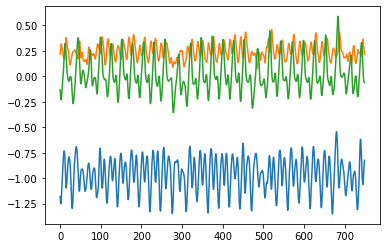

In [8]:
# plot_by_id(smooth7_final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(smooth9_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

## Some definitions

### Prepping the CNN model

In [9]:
def prep_cnn():
    print("Prepping CNN...")
    
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    #filters = [3, 7, 11]

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                     input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    #model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])
    
    print("CNN prepped.")
    
    return model

In [32]:
# Wan et al. also used sinwod size 25, good for borrowing arch

def wan_cnn(save_to=None):
    """The kernel_sizes of each convolutional layer and pooling layer are 7, 3 and 1, 
    and the convolution depth (depth_size) is 64 steps, stride_size= 3, and batch_size= 64. 
    The number of hidden units in the fully connected layer is 512. During the training, 
    we used a dropout layer with the following parameters to prevent overfitting: 0.1, 0.25 and 0.5."""
    
    kernels = [7,3,1]
    dropouts = [0.1,0.25,0.5]
    f=64
    n_features = 6
    n_classes = len(class_labels)
    s=6
    
    model = Sequential()

    model.add(Conv1D(filters=f, kernel_size=kernels[0],
                     input_shape=(window_size, n_features)))
    #They don't mention activation method
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[1]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[1]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[2]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[2]))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'], strides=s)
    
    #save_to_models_comparisons('wan_et_al.txt', model.summary())
    print(model.summary())
    
    return model

In [ ]:
# Wan et al. also used sinwod size 25, good for borrowing arch

def wan_cnn_tinkering(kernels=3, dropout=0.25, filters=64, learning_rate=0.001, nn_units=512):
    """The kernel_sizes of each convolutional layer and pooling layer are 7, 3 and 1, 
    and the convolution depth (depth_size) is 64 steps, stride_size= 3, and batch_size= 64. 
    The number of hidden units in the fully connected layer is 512. During the training, 
    we used a dropout layer with the following parameters to prevent overfitting: 0.1, 0.25 and 0.5."""
    
    #kernels = [7,3,1]
    dropouts = [0.1,0.25,0.5]
    f=filters
    n_features = 6
    n_classes = len(class_labels)
    s=6
    
    model = Sequential()

    model.add(Conv1D(filters=f, kernel_size=kernels[0],
                     input_shape=(window_size, n_features)))
    #They don't mention activation method
    model.add(MaxPooling1D())
    model.add(Dropout(dropout))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[1]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropout))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[2]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'], strides=s)
    
    #save_to_models_comparisons('wan_et_al.txt', model.summary())
    print(model.summary())
    
    return model

In [7]:
def promising_cnn(learning_rate=0.001, filters=128, kernel_size=2):
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    #model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=learning_rate),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [12]:
def promising_cnn_tinkering(filters=64, kernel_size=3):
    filters = filters
    kernel_size = kernel_size
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [6]:
def try_lstm(lstm_units=128, nn_units=128, dropout=0.5, learning_rate=0.01):
    n_features = 6
    n_classes = len(class_labels)
    
    model = Sequential()
    model.add(
        Bidirectional(
          LSTM(
              units=lstm_units,
              input_shape=(window_size, n_features)
          )
        )
    )
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=nn_units, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=learning_rate),
      metrics=['acc']
    )
    
    return model

In [14]:
def cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    # define CNN model
    cnn = Sequential()
    cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    cnn.add(MaxPooling1D())
    cnn.add(Flatten())
    
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))
    """
    model.add(
        Bidirectional(
          LSTM(
              units=128,
              input_shape=(1,704)
          )
        )
    )
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    """
    
    return cnn

In [5]:
def try_cnn_lstm(filters=64, kernel_size=3, learning_rate=0.001, lstm_units=128, nn_units=128, dropout=0.5):
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    model = Sequential([
          Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)),
        MaxPooling1D(),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=activation),
        MaxPooling1D(),
           Bidirectional(LSTM(units=lstm_units)),
        Flatten(),
        Dropout(rate=dropout),
          Dense(units=nn_units, activation='relu'),
        Dense(n_classes, activation='softmax')])
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=learning_rate),
      metrics=['acc']
    )
    
    return model

In [16]:
# multi-headed cnn model
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

def multi_head_cnn(trainX, trainy, testX, testy):
    k1_size, k2_size, k3_size = 3, 5, 11 # 56 / 86
#     k1_size, k2_size, k3_size = 2, 3, 7 # 59 / 89
    filters = 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=filters, kernel_size=k1_size, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=filters, kernel_size=k2_size, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=filters, kernel_size=k3_size, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [17]:
def save_to_models_comparisons(save_to, text):
    model_dir = 'models/comparisons/'
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
        
    f = open(model_dir + save_to, "a")
    f.write(text)
    f.close()

### Format the input

Format data into windows - make (window_size,6) inputs

In [8]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [9]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [10]:
def format_data(X_train_full, y_train_full, X_test_full, y_test_full):
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
    
    X_train = []
    X_test = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size, len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    for window_id, group in X_test_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")

        X_test.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    X_test = np.asarray(X_test)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(np.shape(y_train))
    print(np.shape(y_test))
    
    print("Data formatted.")
    return X_train, y_train, X_test, y_test

In [12]:
def format_all_data(X_train_full, y_train_full):
    # to be used when we only want a training set not test set
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    
    X_train = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size,len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(y_train))
    
    print("Data formatted.")
    return X_train, y_train

### Accuracy of the model (+ on subset)

In [11]:
# This is used for grouping the predictions into subsets
activity_groups = {
 'Sitting/Standing': [0,1,2,3,12], # including desk work
 'Lying': [4,5,6,7],
 'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
 'Running': [9],
 'Falling': [14,15,16,17]
}
    
def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(activity_groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

In [12]:
def evaluate(y_true_labels, y_pred_labels, save_to=None):
    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels, target_names=list(class_labels.keys())))
    
    # compute accuracy of the subset of activities 
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)

    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(grouped_y_true_labels, grouped_y_pred_labels, target_names=list(activity_groups.keys())))

In [13]:
def print_scores(y_true, y_pred, categories):
    conf_mat = confusion_matrix(y_true, y_pred)
    accuracies = conf_mat.diagonal()/conf_mat.sum(axis=1)
    precisions, recalls, fscores, _ = precision_recall_fscore_support(y_true, y_pred)

    max_length = max([len(key) for key in categories])
    for i, cl in enumerate(categories):
        n_dots = max_length + 5 -len(cl)
        print(cl + n_dots * '.' + ' Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F-score: {:.2f}\n'.format(
                accuracies[i], precisions[i], recalls[i], fscores[i]))

In [14]:
def confusion_mat(y_true_labels, y_pred_labels):
    cm = confusion_matrix(y_true_labels, y_pred_labels,normalize='true')
    cm = np.around(cm, 2)

    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_title('Confusion matrix')
    sns.heatmap(cm, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys(), 
                ax=ax, fmt='.2g', vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'}, annot_kws={"size": 9})
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

## Without Cross-validation for development

In [23]:
def prep_dev_data(final_sliding_windows):

    # split data into training and test sets (split by subject)

    subjects = final_sliding_windows['subject_id'].unique()

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

    X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
    y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]
    
    X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
    y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]
    
    # format the data
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    return X_train, y_train, X_test, y_test

In [17]:
def train_dev_model(model, X_train, y_train, batch_size=100, epochs=10):

    # train the model 
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

In [24]:
# Prep data
# Over sample only training data? 
X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_respeck)

Formatting data...
(15134, 25, 6)
(4184, 25, 6)
(15134, 18)
(4184, 18)
Data formatted.


In [53]:
# Over sample only training set
oversample = RandomOverSampler('auto')
#X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
oversample.fit_resample(X_train[:,:,0], np.argmax(y_train, axis=1))
X_train_over = X_train[oversample.sample_indices_]
y_train_over = y_train[oversample.sample_indices_]

C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\imblearn\utils\_validation.py:591: FutureWarning: Pass sampling_strategy=auto as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [54]:
print(np.shape(X_train_over))
print(np.shape(X_test))

print(np.shape(y_train_over))
print(np.shape(y_test))

(19836, 25, 6)
(4184, 25, 6)
(19836, 18)
(4184, 18)


In [56]:
from collections import Counter
print('Oversampled')
print(Counter(np.argmax(y_train_over, axis=1)))
print('Original')
print(Counter(np.argmax(y_train, axis=1)))

Oversampled
Counter({10: 1102, 11: 1102, 12: 1102, 4: 1102, 7: 1102, 6: 1102, 5: 1102, 13: 1102, 9: 1102, 2: 1102, 1: 1102, 0: 1102, 3: 1102, 8: 1102, 14: 1102, 15: 1102, 16: 1102, 17: 1102})
Original
Counter({6: 1102, 7: 1101, 13: 1095, 4: 1093, 5: 1092, 12: 1091, 3: 1090, 2: 1086, 1: 1086, 0: 1084, 8: 1064, 9: 1062, 11: 976, 10: 974, 14: 73, 17: 23, 16: 22, 15: 20})


In [57]:
# # Prep data
# X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

# prepare the model
model = promising_cnn()
# model = multi_head_cnn(X_train, y_train, X_test, y_test)

# Train 
if clean:
    model = train_dev_model(model, X_train_over, y_train_over, batch_size=64, epochs=10)
else:
    model = train_dev_model(model, X_train, y_train, batch_size=64, epochs=10)
#train multi head cnn - 3 inputs
# model = train_dev_model(model, [X_train, X_train, X_train], y_train, batch_size=64, epochs=10)    

# Test the model
y_pred_ohe = model.predict(X_test)
# test multi head cnn - 3 inputs
# y_pred_ohe = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

evaluate(y_true_labels, y_pred_labels)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 12, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 128)            5

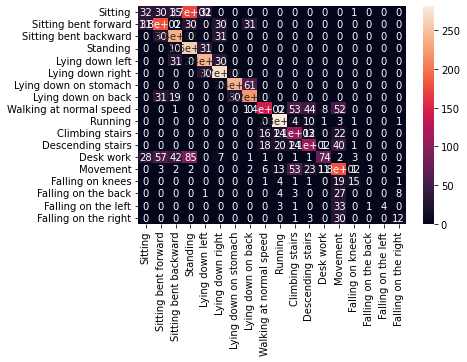

In [58]:
confusion_mat(y_true_labels, y_pred_labels)

## Train baseline model on ALL data

In [161]:
# Note: On Thingy
X = final_sliding_windows_thingy[['window_id'] + columns_of_interest]
y = final_sliding_windows_thingy[['window_id'] + ['activity_type']]

# format the data
X_train, y_train = format_all_data(X, y)
   
# prepare the CNN
model = prep_cnn()

# train the model 
train_dev_model(X_train, y_train)

Formating data...
(30267, 20, 6)
(30267, 18)
Data formatted.
Prepping CNN...
CNN prepped.


## Leave-One-Subject-Out Cross Validation

In [15]:
def get_loocv(final_sliding_windows, n=6):

    loocv = LeaveOneGroupOut()

    # # UNCOMMENT TO LEAVE ONE SUBJECT OUT####
    # # group by subject id so that one subject is left out each time
    # groups = final_sliding_windows['subject_id']
    # ########################################

    # UNCOMMENT TO LEAVE (48 / N) SUBJECTS OUT####
    # n must be a factor of 48 (there are 48 subjects in the dataset)
    #n = 6
    subj_group_mapping = {}
    for i, subj_id in enumerate(final_sliding_windows['subject_id'].unique()):
        subj_group_mapping[subj_id] = i % n
    groups = [ subj_group_mapping[subj_id] for subj_id in final_sliding_windows['subject_id'] ]
    ########################################

    X = final_sliding_windows[['window_id'] + columns_of_interest]
    y = final_sliding_windows[['window_id'] + ['activity_type']]

    # how many different subjects
    loocv.get_n_splits(X, y, groups)
    
    return loocv, X, y, groups

In [17]:
def run_cross_val(final_sliding_windows, model_setup, params={}, n=4,  batch_size=32, epochs=10, oversample=False, verbose=0):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    trained_models = [] # For epoch experiments

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
        if oversample:
            # Over sample only training set
            oversample = RandomOverSampler('auto')
            #X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
            oversample.fit_resample(X_train[:,:,0], np.argmax(y_train, axis=1))
            X_train = X_train[oversample.sample_indices_]
            y_train = y_train[oversample.sample_indices_]

        model = model_setup(**params)

        print("Training...")
        trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
        trained_models.append(trained)
        
        # stats
        y_pred_ohe = model.predict(X_test)
        y_pred_labels = np.concatenate([y_pred_labels, np.argmax(y_pred_ohe, axis=1)])
        y_true_labels = np.concatenate([y_true_labels, np.argmax(y_test, axis=1)])

        print(y_pred_labels.shape)
        print(y_true_labels.shape)

    evaluate(y_true_labels, y_pred_labels)
    
    print_scores(y_true_labels, y_pred_labels, class_labels)
    
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)
    
    print_scores(grouped_y_true_labels, grouped_y_pred_labels, activity_groups)
    
    confusion_mat(y_true_labels, y_pred_labels)
    
    return y_true_labels, y_pred_labels#, trained_models 

Starting iteration 0 of 2
Formatting data...
(11901, 25, 6)
(12378, 25, 6)
(11901, 18)
(12378, 18)
Data formatted.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 128)           512       
_________________________________________________________________
activation_6 (Activation)    (None, 12, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 128)            0         
_____

C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




********************************************************************************
Classification report
********************************************************************************
                  precision    recall  f1-score   support

Sitting/Standing       0.51      0.96      0.67      7093
           Lying       0.03      0.00      0.00      5716
         Walking       0.84      0.86      0.85      5622
         Running       0.73      0.85      0.78      1393
         Falling       0.90      0.67      0.76      4455

        accuracy                           0.65     24279
       macro avg       0.60      0.67      0.61     24279
    weighted avg       0.56      0.65      0.58     24279

Sitting..................... Accuracy: 0.51, Precision: 0.11, Recall: 0.51, F-score: 0.18

Sitting bent forward........ Accuracy: 0.00, Precision: 0.00, Recall: 0.00, F-score: 0.00

Sitting bent backward....... Accuracy: 0.48, Precision: 0.11, Recall: 0.48, F-score: 0.18

Standing........

C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sitting/Standing..... Accuracy: 0.96, Precision: 0.51, Recall: 0.96, F-score: 0.67

Lying................ Accuracy: 0.00, Precision: 0.03, Recall: 0.00, F-score: 0.00

Walking.............. Accuracy: 0.86, Precision: 0.84, Recall: 0.86, F-score: 0.85

Running.............. Accuracy: 0.85, Precision: 0.73, Recall: 0.85, F-score: 0.78

Falling.............. Accuracy: 0.67, Precision: 0.90, Recall: 0.67, F-score: 0.76



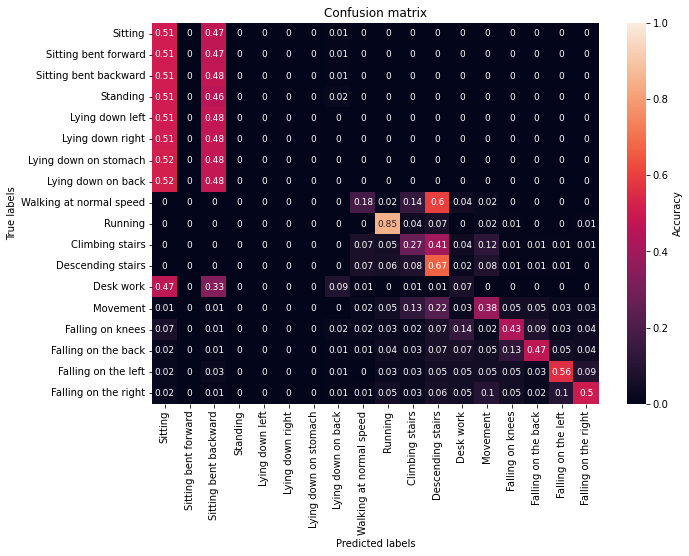

In [20]:
# Running cross-val
params = {}#{'lstm_units':64, 'nn_units':64}
y_t, y_p = run_cross_val(final_sliding_windows_respeck, promising_cnn, params, batch_size=64, epochs=2, n=2, oversample=False)

## Tuning

In [11]:
# Tuning try_lstm
kernels= [2,3]
filters = [16, 32,64,128]
dropouts = [0.0, 0.1, 0.3, 0.5]
lstm_units = [16,32,64,128,256]
nn_units = [32,64,128,256]
batch_sizes = [32, 64, 128, 256]
cnn_epochs = 20
learning_rates = [0.01, 0.001]
lstm_epochs = 10
multihead_kernels = [2,3,5,7,9,11]

In [12]:
comparison_save_dir = 'models/comparisons/'

if not os.path.isdir(comparison_save_dir):
    os.mkdirs(comparison_save_dir)

### Functions and prep data

In [13]:
def get_cv_data(final_sliding_windows, n=3):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    #trained_models = [] # For epoch experiments
    X_trains = []
    y_trains = []
    X_tests = []
    y_tests = []

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
        
        # Yes this is very inefficient space-wise but it is to save time! 
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_tests.append(X_test)
        y_tests.append(y_test)
        
        #df, trained_models = loopparas
    
    return X_trains, y_trains, X_tests, y_tests

In [14]:
def run_model_on_split(X_train, y_train, X_test, y_test, model_setup, params={}, batch_size=64, epochs=10, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)

    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    full_acc = accuracy_score(y_true_labels, y_pred_labels)
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)
    subset_acc = accuracy_score(grouped_y_true_labels, grouped_y_pred_labels)
    
    return full_acc, subset_acc

In [20]:
def epoch_testing(X_train, y_train, X_test, y_test, model_setup, params={}, epochs=10, batch_size=64, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return trained

In [15]:
# Get the train and test splits for each cross val
X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_respeck)

Starting iteration 0 of 3
Formatting data...
(14858, 25, 6)
(8243, 25, 6)
(14858, 18)
(8243, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15463, 25, 6)
(7638, 25, 6)
(15463, 18)
(7638, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(15881, 25, 6)
(7220, 25, 6)
(15881, 18)
(7220, 18)
Data formatted.


In [16]:
del final_sliding_windows_respeck

### Tune Epochs and Dropout rate

Make sure that the model setup function has defaults specified for everything!

In [38]:
# EPOCHS EXPERIMENT FOR TRY_LSTM

model_setup = try_lstm
epochs = lstm_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'try_lstm_epochs_dropouts_respeck_lr0p001.txt'
res = []

columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

for dropout in [0.5]:#dropouts:
    params = {'dropout':dropout, 'learning_rate':0.001} # Otherwise run with default parameters
    print(params)
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['acc']
            r += trained_model.history['val_acc']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))
            
df = pd.DataFrame(res, columns=columns)
df.to_csv(comparison_save_dir + save_file)
    

{'dropout': 0.5, 'learning_rate': 0.001}
	Data split 0 @ 22:47:42
	Data split 1 @ 22:58:58
	Data split 2 @ 23:11:33


In [22]:
# EPOCHS EXPERIMENT FOR TRY_CNN_LSTM

model_setup = try_cnn_lstm
epochs = lstm_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'try_cnn_lstm_epochs_dropouts_respeck.txt'
res = []

columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

for dropout in [0.5]:
    params = {'dropout':dropout} # Otherwise run with default parameters
    print(params)
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['acc']
            r += trained_model.history['val_acc']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))
            
df = pd.DataFrame(res, columns=columns)
df.to_csv(comparison_save_dir + save_file)
    

{'dropout': 0.5}
	Data split 0 @ 21:27:14
	Data split 1 @ 21:27:54
	Data split 2 @ 21:28:36


### Plot epoch results from file

Number of plots you should see (otherwise change rows & cols in subplots): 1


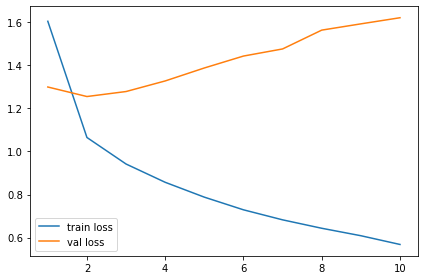

In [24]:
epoch_file = 'try_cnn_lstm_epochs_dropouts_respeck.txt'
df = pd.read_csv(comparison_save_dir + epoch_file)

def acc_plot(to_plot, ax):
    acc_cols = [c for c in columns if c[:4] == 'loss']
    val_acc_cols = [c for c in columns if c[:8] == 'val_loss']
    #acc_cols = [c for c in columns if c[:3] == 'acc']
    #val_acc_cols = [c for c in columns if c[:7] == 'val_acc']
    epochs = np.arange(len(acc_cols)) + 1

    ax.plot(epochs, df[acc_cols].mean(), label='train loss')
    ax.plot(epochs, df[val_acc_cols].mean(), label='val loss')
    ax.legend()

print('Number of plots you should see (otherwise change rows & cols in subplots): {}'.format(len(df['title'].unique())))
    
if len(df['title'].unique()) == 1:
    acc_plot(df, plt)
       
else:
    # You need to set the no. of rows and cols manually
    fig, axs = plt.subplots(2,2, figsize=(10,7)) 

    axs = axs.flatten()

    for i, title in enumerate(df['title'].unique()):
        axs[i].set_title(title)
        to_plot = df[df['title']==title]
        acc_plot(to_plot, axs[i])

    
plt.tight_layout()
plt.show()

### Tune model parameters

Make sure to run get_cv_data first

In [24]:
# MODEL PARAMETER EXPERIMENT FOR TRY_LSTM

lstm_units = [32,64,128]
nn_units = [64,128]
batch_sizes = [64, 128]
learning_rates = [0.01,0.001]

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 4
dropout = 0.5
save_file = 'try_lstm_parameter_search_respeck.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# LSTM
# Change loops
for lstm_unit in lstm_units:
    for nn_unit in nn_units:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                # Change this
                params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                print('\n' + str(params) + ', batch size: ' + str(batch_size))
                accs = []
                saccs = []
                for i in range(n):
                    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                    try:
                        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                        accs.append(acc)
                        saccs.append(sacc)
                        
                    except Exception as ex:
                        print('\tException: ' +  str(ex))
                    
                # Change this - must match columns!
                results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)


{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 21:30:23
	Iteration 1 @ 21:30:42
	Iteration 2 @ 21:31:04

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 21:31:26
	Iteration 1 @ 21:31:48
	Iteration 2 @ 21:32:10

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 21:32:35
	Iteration 1 @ 21:32:50
	Iteration 2 @ 21:33:04

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 21:33:19
	Iteration 1 @ 21:33:32
	Iteration 2 @ 21:33:47

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 21:34:01
	Iteration 1 @ 21:34:22
	Iteration 2 @ 21:34:45

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 21:35:08
	Iteration 1 @ 21:35:28
	Iteration 2 @ 21:35:48

{'dropout': 0.

In [17]:
# MODEL PARAMETER EXPERIMENT FOR TRY_CNN_LSTM

lstm_units = [32,64,128]
nn_units = [64,128]
filters = [32,64,128]
batch_sizes = [64,128]
learning_rates = [0.01,0.001]
kernels= [2,3]

n=3 # Cross-val n used in get_cv_data
model_setup = try_cnn_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 3
dropout = 0.5
save_file = 'try_cnn_lstm_parameter_search_respeck.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'dropout', 'filters', 'kernels', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# LSTM
# Change loops
for f in filters:
    for k in kernels:
        for lstm_unit in lstm_units:
            for nn_unit in nn_units:
                for batch_size in batch_sizes:
                    for learning_rate in learning_rates:
                        # Change this
                        params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'kernel_size':k, 'filters':f, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                        print('\n' + str(params) + ', batch size: ' + str(batch_size))
                        accs = []
                        saccs = []
                        for i in range(n):
                            print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                            try:
                                acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                                accs.append(acc)
                                saccs.append(sacc)

                            except Exception as ex:
                                print('\tException: ' +  str(ex))
                                
                        # Change this - must match columns!
                        results.append([epochs, dropout, f, k, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
                                
    print('Saving to ' + comparison_save_dir + 'temp_try_cnn_lstm_parameter_search_respeck_filter' + str(f) + 'csv')
    df = pd.DataFrame(results, columns=columns)
    df.to_csv(comparison_save_dir + save_file)

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)


{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 23:01:21
	Iteration 1 @ 23:01:32
	Iteration 2 @ 23:01:42

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 23:01:52
	Iteration 1 @ 23:02:02
	Iteration 2 @ 23:02:12

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 23:02:23
	Iteration 1 @ 23:02:32
	Iteration 2 @ 23:02:41

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 23:02:49
	Iteration 1 @ 23:02:57
	Iteration 2 @ 23:03:05

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 23:03:13
	Iteration 1 @ 23:03:23
	Iteration 2 @ 23:03:34

{'dropout': 0.

	Iteration 1 @ 23:25:41
	Iteration 2 @ 23:26:07

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 64, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 23:26:33
	Iteration 1 @ 23:26:54
	Iteration 2 @ 23:27:19

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 64, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 23:28:01
	Iteration 1 @ 23:28:34
	Iteration 2 @ 23:29:07

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 128, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 23:29:41
	Iteration 1 @ 23:30:15
	Iteration 2 @ 23:30:50

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 128, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 23:31:24
	Iteration 1 @ 23:31:56
	Iteration 2 @ 23:32:29

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 128, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 23:33:02
	Iterat

	Iteration 1 @ 00:22:46
	Iteration 2 @ 00:23:09

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 64, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 00:23:32
	Iteration 1 @ 00:23:54
	Iteration 2 @ 00:24:17

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 00:24:40
	Iteration 1 @ 00:24:59
	Iteration 2 @ 00:25:21

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 00:28:14
	Iteration 1 @ 00:28:43
	Iteration 2 @ 00:29:13

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 00:29:45
	Iteration 1 @ 00:30:21
	Iteration 2 @ 00:30:55

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 00:31:30
	Iteration

	Iteration 1 @ 02:55:13
	Iteration 2 @ 02:55:48

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 02:56:22
	Iteration 1 @ 02:57:01
	Iteration 2 @ 02:57:40

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 02:58:19
	Iteration 1 @ 02:58:56
	Iteration 2 @ 02:59:35

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 03:00:14
	Iteration 1 @ 03:00:45
	Iteration 2 @ 03:01:17

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 03:01:49
	Iteration 1 @ 03:02:20
	Iteration 2 @ 03:22:42

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 64, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 03:23:48
	Iterat

### Smoothing experiment - promising CNN

In [132]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = promising_cnn # Change this

# Set these from epoch experiment (Change this)
epochs = 10
# dropout = 0.5
batch_size = 64
save_file = 'respeck_promising_cnn_smooth9.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 14:40:32
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 11, 64)            256       
_________________________________________________________________
activation_96 (Activation)   (None, 11, 64)            0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_97 (Batc 

### Smoothing experiment - try lstm

In [47]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 5
# dropout = 0.5
batch_size = 64
save_file = 'thingy_try_lstm_smooth0.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 15:56:05
	Iteration 1 @ 15:58:44
	Iteration 2 @ 16:01:36
Saving to models/comparisons/thingy_try_lstm_smooth0.csv


### Save a test instance

In [41]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [123]:
# Saving the model to file
model_name = 'cnn_simple_full_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\cnn_simple_full_thingy\assets


473324